In [1]:
import pandas as pd
from CosinorPy import file_parser, cosinor, cosinor1
import numpy as np

In [31]:
transcriptome = pd.read_csv('/Users/michael/Data/Luke_terrace_experiment/General_data/plate1_4_tpm_normalized.csv', index_col = 0)
rows_to_drop_expression_data = ['A2450525897_n01_undetermined',
                'A2449446903_n01_undetermined',
                'B250508004_n01_undetermined',
                'B2449500127_n01_undetermined']
transcriptome = transcriptome.drop(index = rows_to_drop_expression_data)
transcriptome = transcriptome.sort_index()
metadata = pd.read_csv('/Users/michael/Data/Luke_terrace_experiment/General_data/Plates_1_to_4_metadata_merged_luke_plate_5_graft.csv', index_col = 0,)
metadata = metadata.drop(columns= ['arb.sort','sample-id','Ambiguous Unstranded','Ambiguous Forward','Multimapping','Unmapped Over Mapped'])
metadata['Date and Time'] = metadata['date'] +' ' +  metadata['time']
luke_time_data_format = "%-m/%-d/%y %-H:%-M"
metadata['Date and Time'] = pd.to_datetime(metadata['Date and Time'], format = luke_time_data_format)
unusable_samples = [
    "A2450525897_n01_LICRNA01_A06",
    "A2450525897_n01_LICRNA01_A08",
    "A2450525897_n01_LICRNA01_C11",
    "A2450525897_n01_LICRNA01_D11",
    "A2450525897_n01_LICRNA01_D12",
    "A2449446903_n01_LICRNA02_F01",
    "B2449500127_n01_LICRNA04_A04",
    "B2449500127_n01_LICRNA04_A06",
    "B2449500127_n01_LICRNA04_A07",

]
borderline_unusable = ['A2450525897_n01_LICRNA01_F03', 'A2450525897_n01_LICRNA01_G07','A2449446903_n01_LICRNA02_A04','A2449446903_n01_LICRNA02_H10',"B2449500127_n01_LICRNA04_H02","B2449500127_n01_LICRNA04_H11"]
all_unsable = borderline_unusable+unusable_samples
trimmed_transcriptome = transcriptome.drop(index = all_unsable)
trimmed_metadata = metadata.drop(index= all_unsable)


In [32]:
circadian_metadata = trimmed_metadata.loc[trimmed_metadata['Experiment Type'].str.contains('Circadian')]
circadian_transcriptome = trimmed_transcriptome.loc[trimmed_metadata['Experiment Type'].str.contains('Circadian')]

circadian_expt_2_start_time = circadian_metadata.loc[circadian_metadata['Experiment Type'] == 'Circadian Experiment 2']['Date and Time'].min()
circadian_metadata['Time Since Start'] = (circadian_metadata['Date and Time'] - circadian_metadata['Date and Time'].iloc[0])/pd.Timedelta(hours=1)
circadian_metadata['Time Since Start'].loc[circadian_metadata['Experiment Type'] == 'Circadian Experiment 2'] = (circadian_metadata.loc[circadian_metadata['Experiment Type'] == 'Circadian Experiment 2']['Date and Time'] - circadian_expt_2_start_time)/pd.Timedelta(hours=1)

/var/folders/nk/6xkk9sgn1pz4ff1b36sfq3y40000gt/T/ipykernel_1532/2927211962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circadian_metadata['Time Since Start'] = (circadian_metadata['Date and Time'] - circadian_metadata['Date and Time'].iloc[0])/pd.Timedelta(hours=1)
/var/folders/nk/6xkk9sgn1pz4ff1b36sfq3y40000gt/T/ipykernel_1532/2927211962.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.

In [44]:
microbiome_abundance = pd.read_csv('/Users/michael/Data/Luke_terrace_experiment/Microbiome/lic2024_16S_rab.csv')
circadian_microbiome = microbiome_abundance.merge(metadata[['sampID','Experiment Type']], left_on= 'plantID', right_on='sampID')
circadian_microbiome = circadian_microbiome.loc[circadian_microbiome['Experiment Type'] == 'Circadian Experiment 1']

genus_sum = circadian_microbiome[['Sample','Genus','AbundR100']].groupby(['Sample','Genus']).sum()
genus_sum = genus_sum.reset_index()
genus_sum_w_tp = genus_sum.merge(metadata[['sampID','timepoint']], left_on = 'Sample', right_on= 'sampID')
all_present_genus = genus_sum_w_tp['Genus'].unique()

## Need to fill in missing genus in every sample first
for sampID in genus_sum_w_tp['sampID'].unique():
    sampid_only_df = genus_sum_w_tp.loc[genus_sum_w_tp['sampID'] == sampID ]
    present_genus_in_samp = sampid_only_df['Genus'].unique()
    difference_in_present_bacteria = list(set(all_present_genus) - set(present_genus_in_samp))
    current_time_point = sampid_only_df['timepoint'].iloc[0]
    empty_df_to_add = pd.DataFrame(columns = ['Sample','Genus','AbundR100','sampID','timepoint'])
    empty_df_to_add['Genus'] = difference_in_present_bacteria
    empty_df_to_add['Sample'] = sampID
    empty_df_to_add['AbundR100'] = 0
    empty_df_to_add['sampID'] = sampID
    empty_df_to_add['timepoint'] = current_time_point
    genus_sum_w_tp = pd.concat([genus_sum_w_tp,empty_df_to_add])


timepoint_average_abundance = genus_sum_w_tp[["Genus","timepoint","AbundR100"]].groupby(['Genus','timepoint']).mean()
timepoint_average_abundance = timepoint_average_abundance.reset_index()
timepoint_cleaned_average_abundance = timepoint_average_abundance.copy()
for genus in timepoint_cleaned_average_abundance['Genus'].unique():
    genus_df = timepoint_cleaned_average_abundance.loc[timepoint_cleaned_average_abundance['Genus'] == genus]
    if sum(genus_df['AbundR100']>0) < 8:
        timepoint_cleaned_average_abundance = timepoint_cleaned_average_abundance.loc[timepoint_cleaned_average_abundance['Genus'] != genus]


In [45]:
print(timepoint_cleaned_average_abundance['Genus'].unique())


['Actinomycetospora' 'Actinoplanes' 'Aeromicrobium' 'Aetherobacter'
 'Agrobacterium' 'Aureimonas_A_501549' 'Blastococcus' 'Brevundimonas'
 'Caldora' 'Chryseobacterium_A_796612' 'Flavobacterium' 'Friedmanniella'
 'Frigoribacterium' 'Herbaspirillum' 'Hylemonella'
 'Janthinobacterium_571130' 'Janthinobacterium_571526' 'Kineococcus'
 'Kineosporia' 'Klenkia' 'Kordiimonas' 'Massilia_573596' 'Massilia_574424'
 'Massilia_574544' 'Methylobacterium' 'Microbacterium_A_383321'
 'Mycobacterium' 'Nakamurella' 'Neorhizobium_500197'
 'Nocardioides_A_392796' 'Paucimonas' 'Pigmentiphaga'
 'Pseudoduganella_570666' 'Pseudomonas_E_647464' 'Ramlibacter_588642'
 'Rathayibacter' 'Rhodoferax_C' 'Rugamonas_570800' 'Sphingomonas_L_486704'
 'Telluria_573210' 'Variovorax']


In [46]:
timepoint_cleaned_average_abundance = timepoint_cleaned_average_abundance.merge(circadian_metadata[['timepoint','Time Since Start']], left_on = 'timepoint', right_on = 'timepoint')

In [47]:
timepoint_cleaned_average_abundance

,Genus,timepoint,AbundR100,Time Since Start
0,Actinomycetospora,c1_t01,0.375,0.0
1,Actinomycetospora,c1_t01,0.375,0.0
2,Actinomycetospora,c1_t01,0.375,0.0
3,Actinomycetospora,c1_t01,0.375,0.0
4,Actinomycetospora,c1_t01,0.375,0.0
...,...,...,...,...
4464,Variovorax,c1_t13,3.775,48.0
4465,Variovorax,c1_t13,3.775,48.0
4466,Variovorax,c1_t13,3.775,48.0
4467,Variovorax,c1_t13,3.775,48.0


In [48]:
timepoint_formatted_for_cosinor = timepoint_cleaned_average_abundance.rename(columns = {'Time Since Start':'x', 'AbundR100':'y', 'Genus':'test'})
timepoint_formatted_for_cosinor = timepoint_formatted_for_cosinor[['test','x','y']]
timepoint_formatted_for_cosinor

,test,x,y
0,Actinomycetospora,0.0,0.375
1,Actinomycetospora,0.0,0.375
2,Actinomycetospora,0.0,0.375
3,Actinomycetospora,0.0,0.375
4,Actinomycetospora,0.0,0.375
...,...,...,...
4464,Variovorax,48.0,3.775
4465,Variovorax,48.0,3.775
4466,Variovorax,48.0,3.775
4467,Variovorax,48.0,3.775


In [50]:
timepoint_formatted_for_cosinor.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Circadian_experiment_1_microbiome_cosinor_plotting_data.csv', index = False)

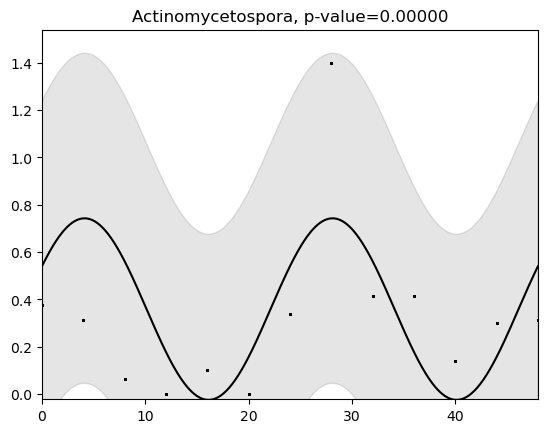

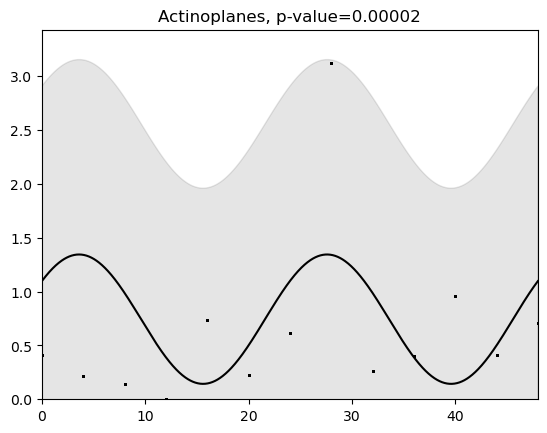

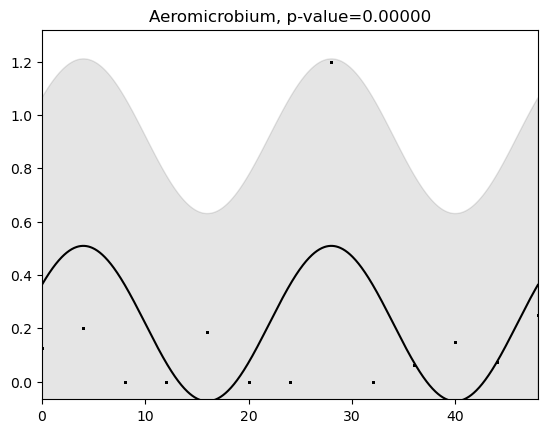

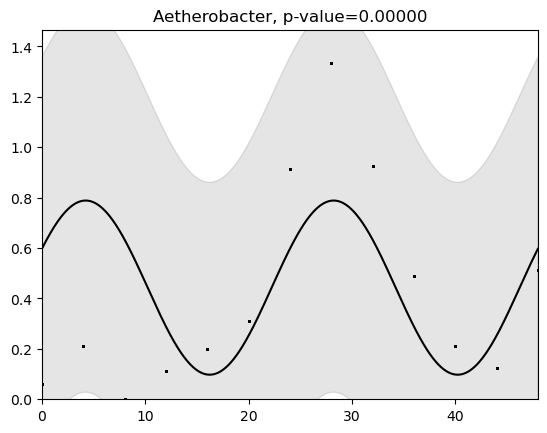

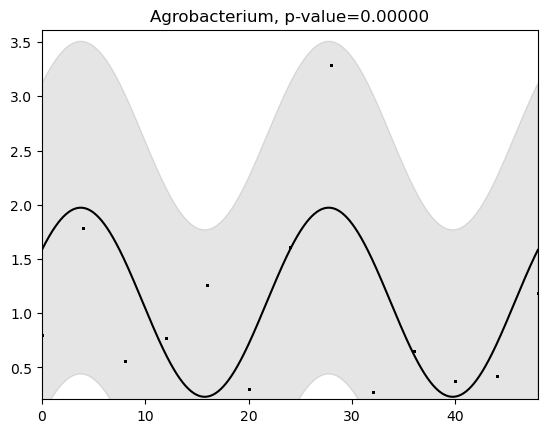

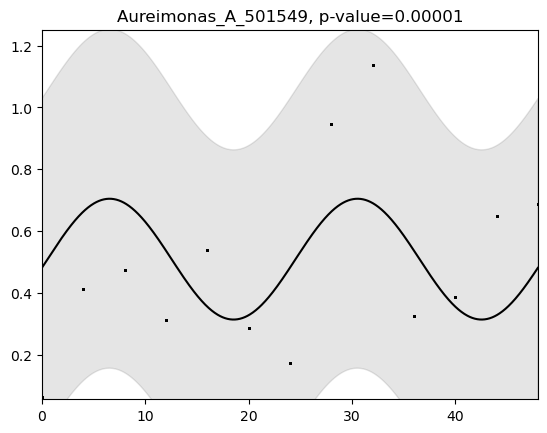

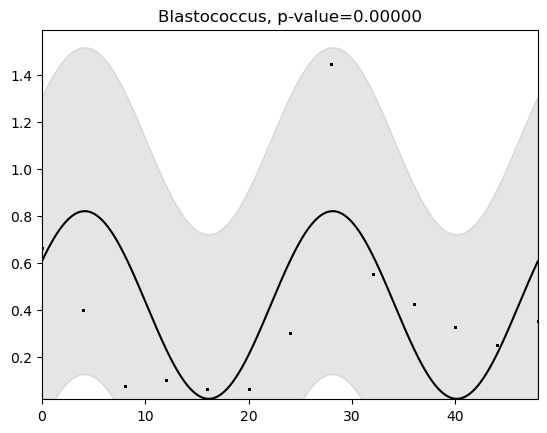

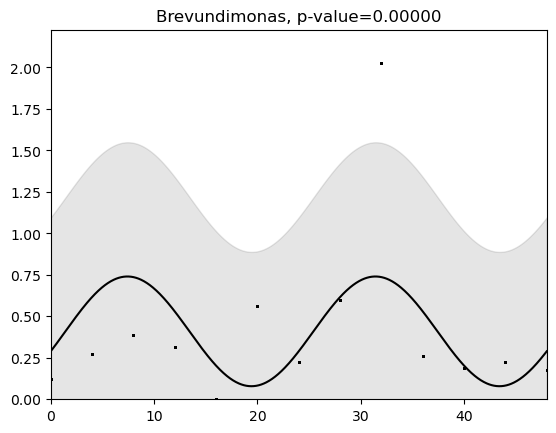

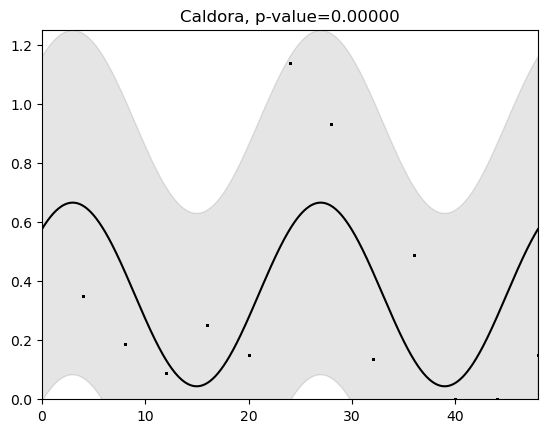

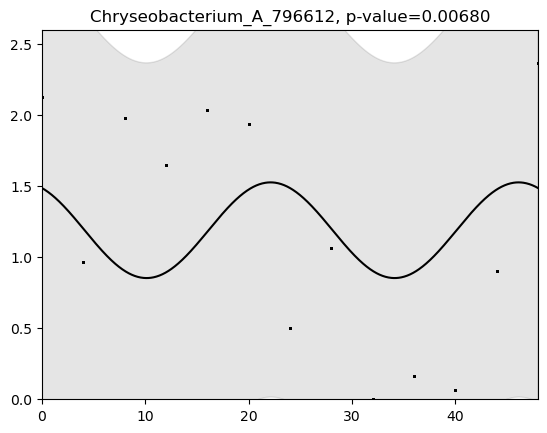

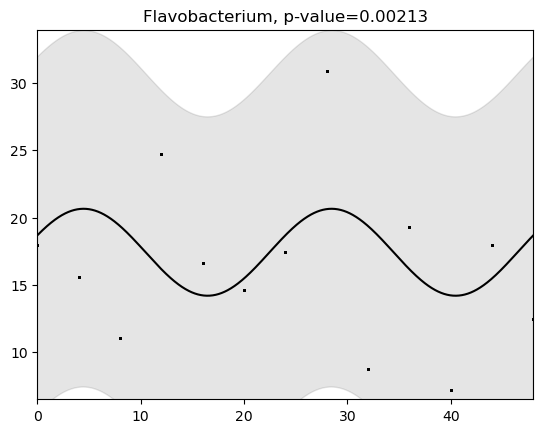

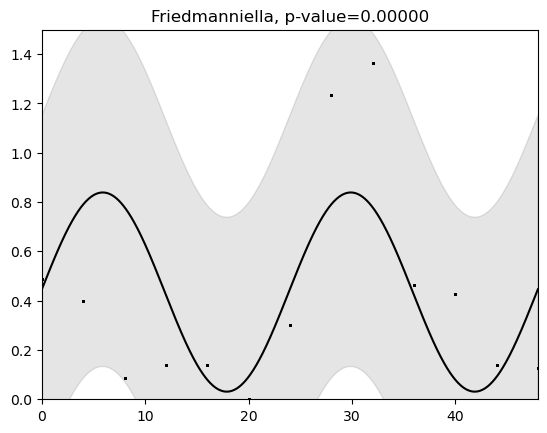

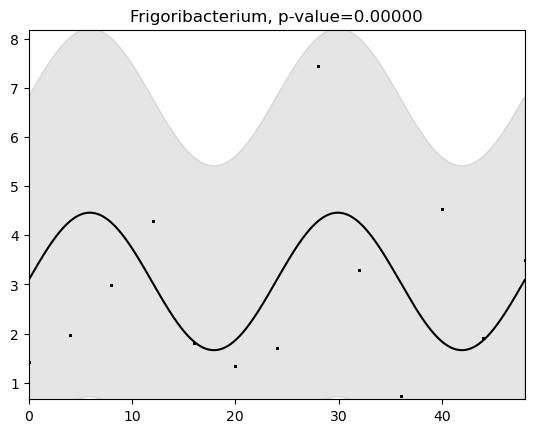

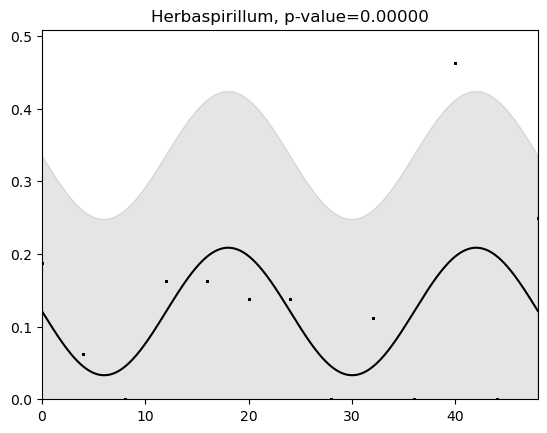

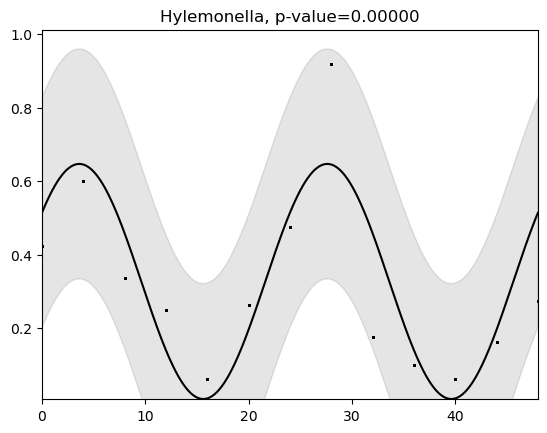

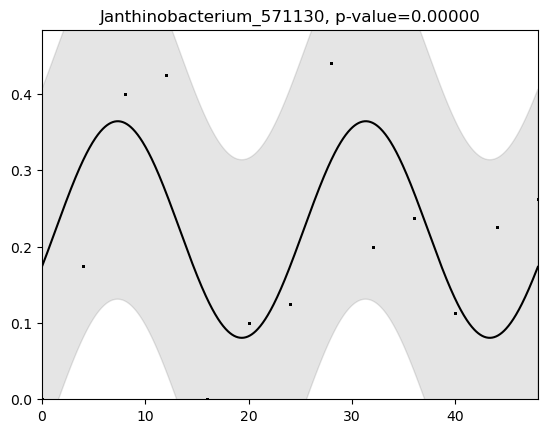

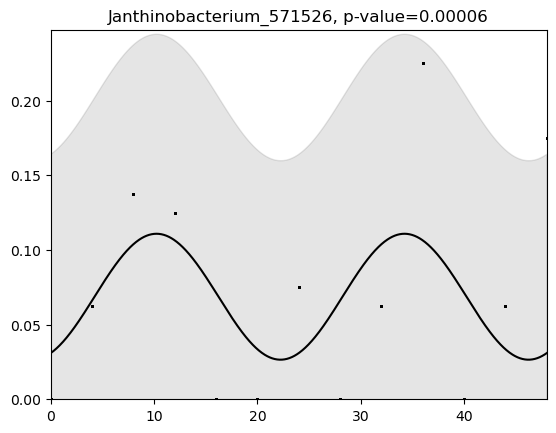

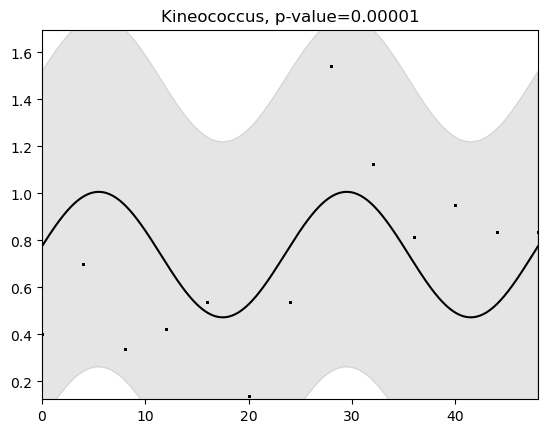

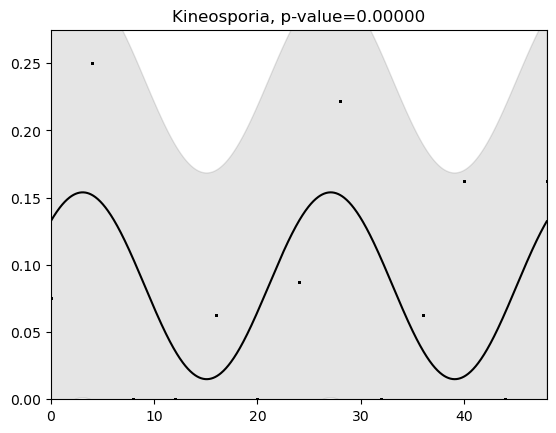

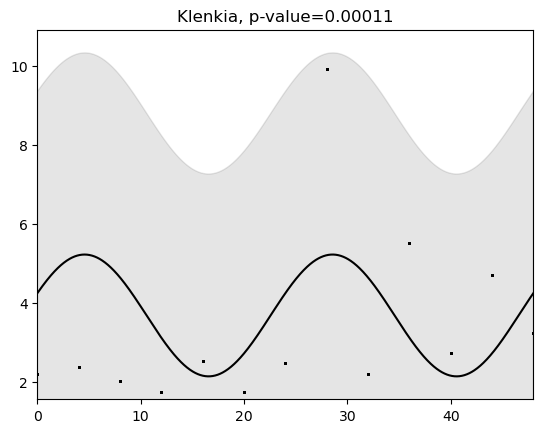

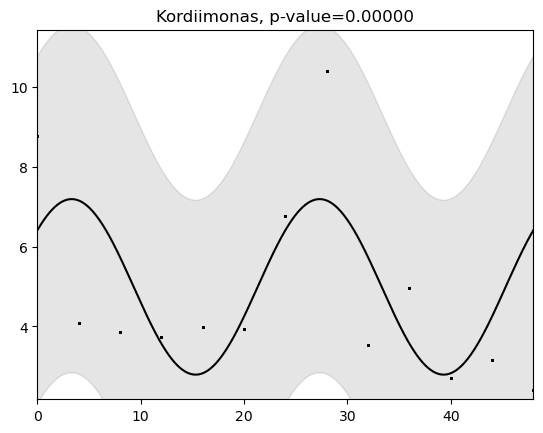

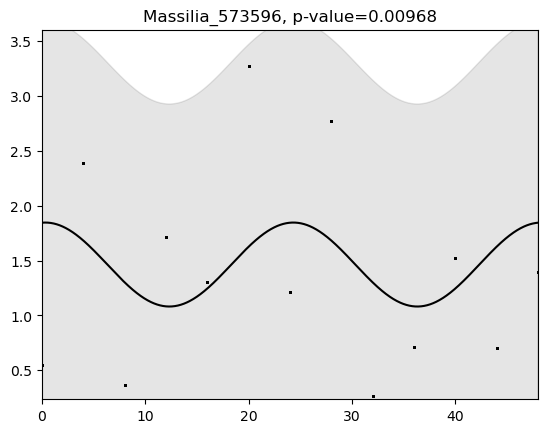

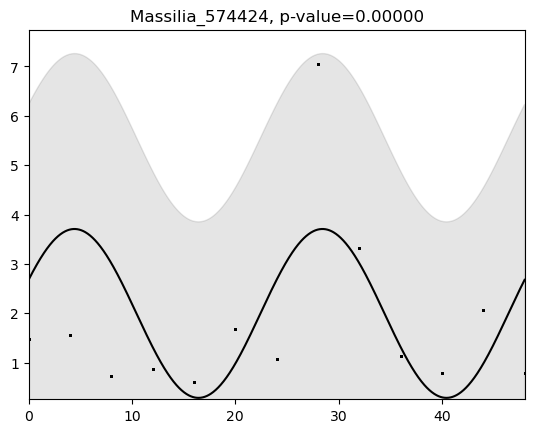

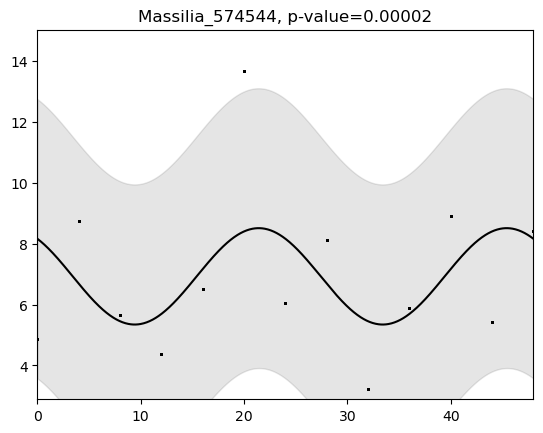

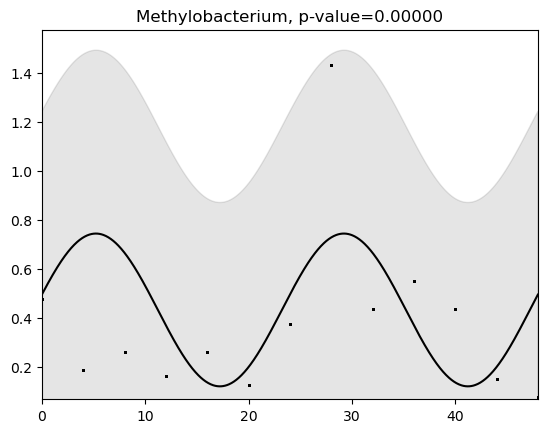

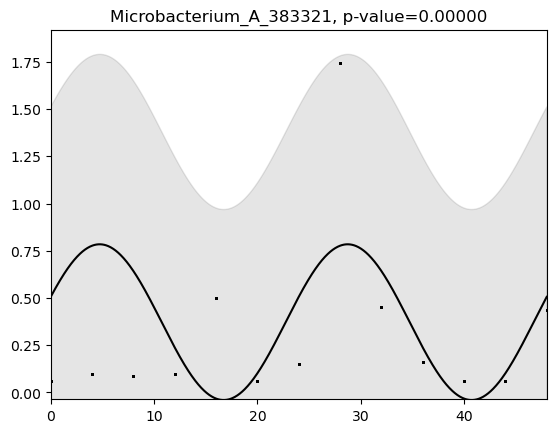

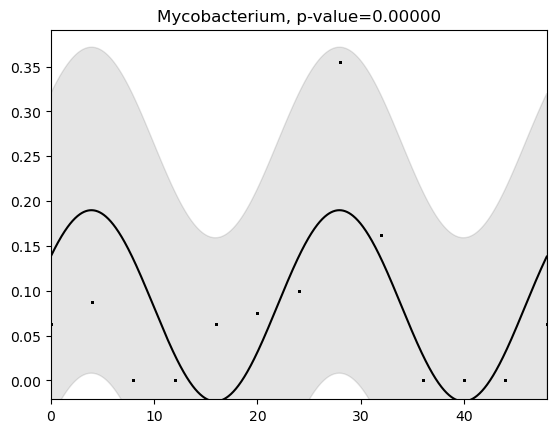

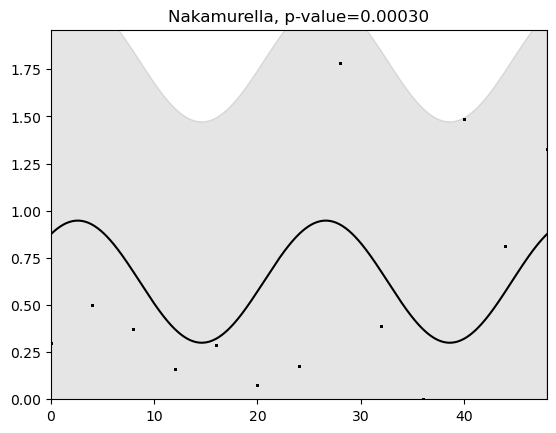

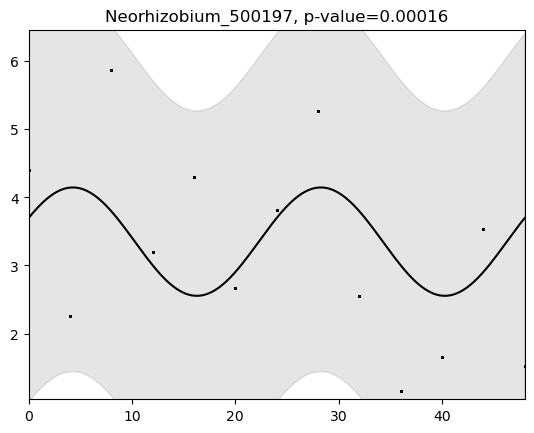

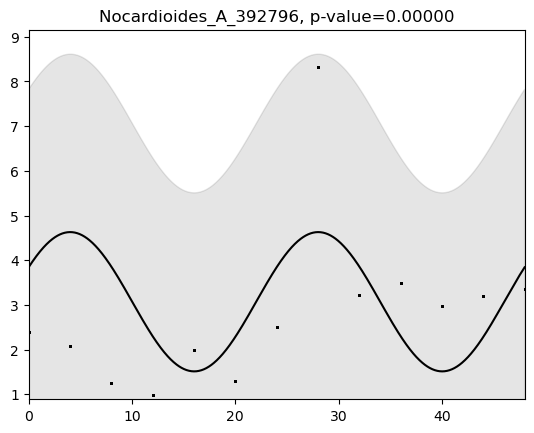

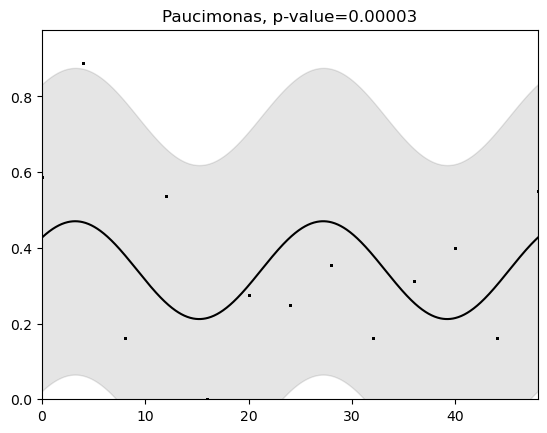

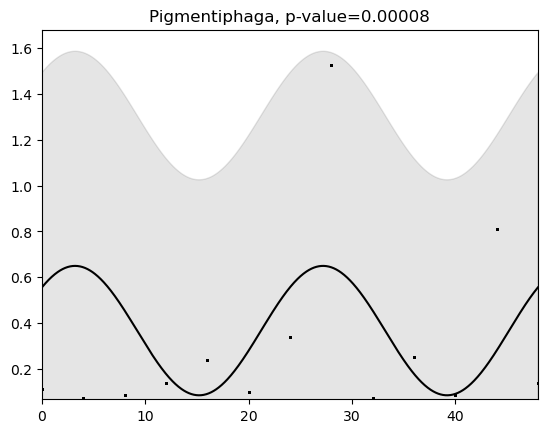

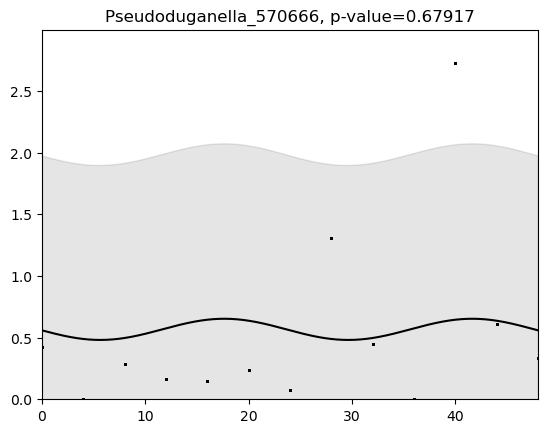

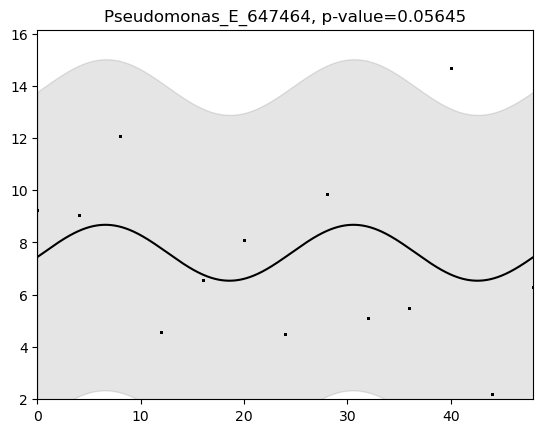

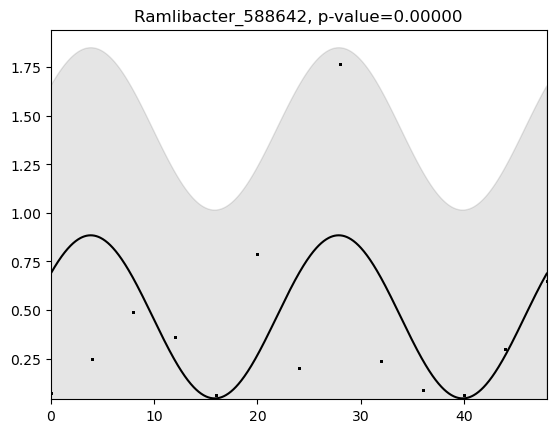

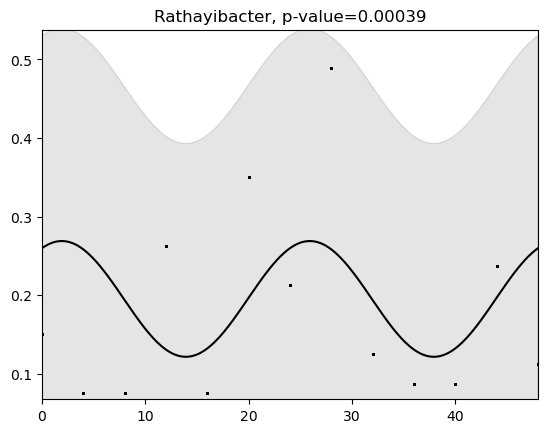

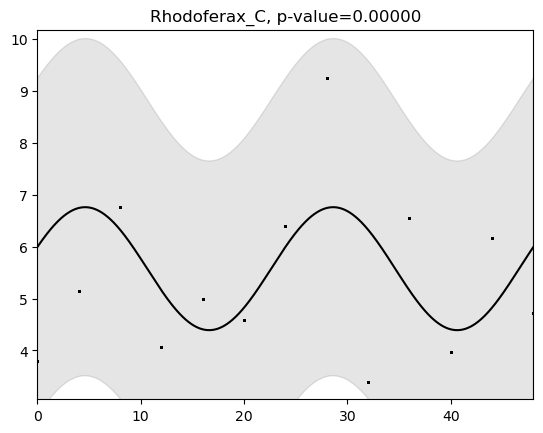

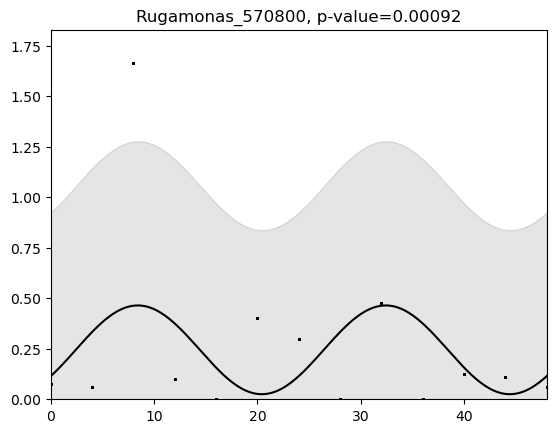

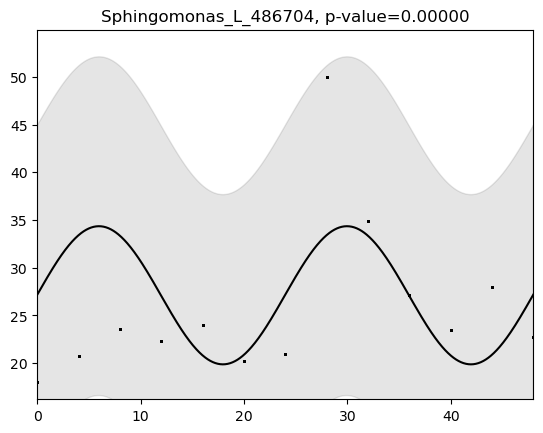

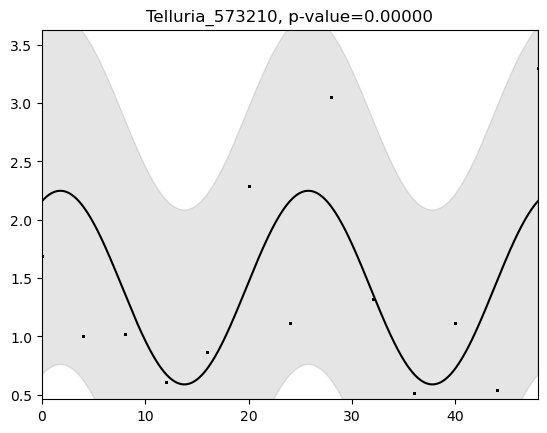

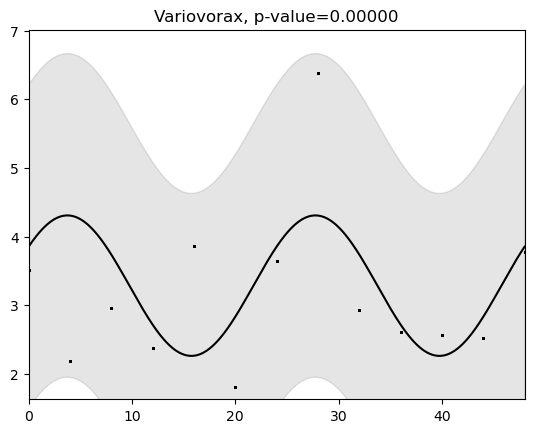

In [49]:
cosinor_results = cosinor1.fit_group(timepoint_formatted_for_cosinor, period = [24])

In [51]:
cosinor_results.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Circadian_experiment_1_microbiome_cosinor_results.csv', index = False)

In [68]:
cosinor_results

,test,period,p,q,amplitude,p(amplitude),q(amplitude),CI(amplitude),acrophase,p(acrophase),q(acrophase),CI(acrophase),acrophase[h]
0,Actinomycetospora,24.0,5.379308e-12,2.766501e-11,0.383651,3.047744e-16,1.567411e-15,"[0.291630396333432, 0.47567254311538676]",-1.081838,6.856343e-18,2.468284e-17,"[-1.327897921329411, -0.8357787741086257]",4.132318
1,Actinoplanes,24.0,1.515468e-05,2.368931e-05,0.600663,6.900296e-07,1.080046e-06,"[0.36350704159520214, 0.8378191821456924]",-0.942379,6.815204e-06,9.813894e-06,"[-1.3528863034304124, -0.5318714846963519]",3.599622
2,Aetherobacter,24.0,5.978572e-09,1.956624e-08,0.345548,1.616941e-11,5.291806e-11,"[0.24501946864477123, 0.4460770634737622]",-1.109849,2.667294e-13,6.001412e-13,"[-1.4074145149139605, -0.8122838529378874]",4.239312
3,Agrobacterium,24.0,1.128190e-12,1.015371e-11,0.871859,2.181700e-17,1.963530e-16,"[0.6704358865537218, 1.073282661327319]",-0.984750,7.278634e-16,2.015622e-15,"[-1.2240430416224108, -0.7454577225670973]",3.761469
4,Aureimonas_A_501549,24.0,7.760615e-06,1.269919e-05,0.195302,2.911548e-07,4.764351e-07,"[0.12067146970843007, 0.2699316454512998]",-1.715619,4.324284e-20,2.594571e-19,"[-2.0819228279376887, -1.3493143714203895]",6.553180
5,Blastococcus,24.0,9.247049e-13,1.015371e-11,0.399117,1.590179e-17,1.908215e-16,"[0.3073072149039414, 0.4909267356202305]",-1.086556,1.733470e-19,7.803712e-19,"[-1.3224212990092707, -0.850691131094987]",4.150339
6,Brevundimonas,24.0,3.659592e-07,7.749723e-07,0.330625,4.997165e-09,1.058223e-08,"[0.2198016341469156, 0.44144802465301924]",-1.943269,3.057935e-33,2.752142e-32,"[-2.260336104381141, -1.6262023927273979]",7.422742
7,Caldora,24.0,1.174420e-11,5.284891e-11,0.310880,1.029738e-15,4.633819e-15,"[0.23493692534154612, 0.386823883046449]",-0.781499,2.514597e-09,4.114796e-09,"[-1.0384761442245374, -0.5245227742938336]",2.985108
8,Chryseobacterium_A_796612,24.0,6.802529e-03,7.420940e-03,0.336398,1.234972e-03,1.347242e-03,"[0.13231437725941173, 0.5404809990485882]",0.488410,1.055308e-01,1.117385e-01,"[-0.10300168951299726, 1.0798207898939212]",22.134413
9,Flavobacterium,24.0,2.125387e-03,2.391060e-03,3.225167,3.098560e-04,3.485880e-04,"[1.4726425179598766, 4.9776911621599345]",-1.167598,3.418771e-05,4.558362e-05,"[-1.719882393676773, -0.6153144360048817]",4.459897


In [ ]:
circadian_microbiome = microbiome_abundance.merge(metadata[['sampID','Experiment Type']], left_on= 'plantID', right_on='sampID')
circadian_microbiome_2 = circadian_microbiome.loc[circadian_microbiome['Experiment Type'] == 'Circadian Experiment 2']

genus_sum_2 = circadian_microbiome_2[['Sample','Genus','AbundR100']].groupby(['Sample','Genus']).sum()
genus_sum_2 = genus_sum_2.reset_index()
genus_sum_w_tp_2 = genus_sum_2.merge(metadata[['sampID','timepoint']], left_on = 'Sample', right_on= 'sampID')
all_present_genus_2 = genus_sum_w_tp_2['Genus'].unique()

## Need to fill in missing genus in every sample first
for sampID in genus_sum_w_tp_2['sampID'].unique():
    sampid_only_df_2 = genus_sum_w_tp_2.loc[genus_sum_w_tp_2['sampID'] == sampID ]
    present_genus_in_samp_2 = sampid_only_df_2['Genus'].unique()
    difference_in_present_bacteria_2 = list(set(all_present_genus_2) - set(present_genus_in_samp_2))
    current_time_point_2 = sampid_only_df_2['timepoint'].iloc[0]
    empty_df_to_add_2 = pd.DataFrame(columns = ['Sample','Genus','AbundR100','sampID','timepoint'])
    empty_df_to_add_2['Genus'] = difference_in_present_bacteria_2
    empty_df_to_add_2['Sample'] = sampID
    empty_df_to_add_2['AbundR100'] = 0
    empty_df_to_add_2['sampID'] = sampID
    empty_df_to_add_2['timepoint'] = current_time_point_2
    genus_sum_w_tp_2 = pd.concat([genus_sum_w_tp_2,empty_df_to_add_2])


timepoint_average_abundance_2 = genus_sum_w_tp_2[["Genus","timepoint","AbundR100"]].groupby(['Genus','timepoint']).mean()
timepoint_average_abundance_2 = timepoint_average_abundance_2.reset_index()
timepoint_cleaned_average_abundance_2 = timepoint_average_abundance_2.copy()
for genus in timepoint_cleaned_average_abundance_2['Genus'].unique():
    genus_df = timepoint_cleaned_average_abundance_2.loc[timepoint_cleaned_average_abundance_2['Genus'] == genus]
    if sum(genus_df['AbundR100']>0) < 8:
        timepoint_cleaned_average_abundance_2 = timepoint_cleaned_average_abundance_2.loc[timepoint_cleaned_average_abundance_2['Genus'] != genus]
timepoint_cleaned_average_abundance_2 = timepoint_cleaned_average_abundance_2.merge(circadian_metadata[['timepoint','Time Since Start']], left_on = 'timepoint', right_on = 'timepoint')

In [41]:
timepoint_formatted_for_cosinor_2 = timepoint_cleaned_average_abundance_2.rename(columns = {'Time Since Start':'x', 'AbundR100':'y', 'Genus':'test'})
timepoint_formatted_for_cosinor_2 = timepoint_formatted_for_cosinor_2[['test','x','y']]
timepoint_formatted_for_cosinor_2

,test,x,y
0,Actinomycetospora,0.0,0.216667
1,Actinomycetospora,0.0,0.216667
2,Actinomycetospora,0.0,0.216667
3,Actinomycetospora,0.0,0.216667
4,Actinomycetospora,0.0,0.216667
...,...,...,...
4177,Variovorax,48.0,3.587500
4178,Variovorax,48.0,3.587500
4179,Variovorax,48.0,3.587500
4180,Variovorax,48.0,3.587500


In [52]:
timepoint_formatted_for_cosinor_2.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Circadian_experiment_2_microbiome_cosinor_plotting_data.csv', index = False)

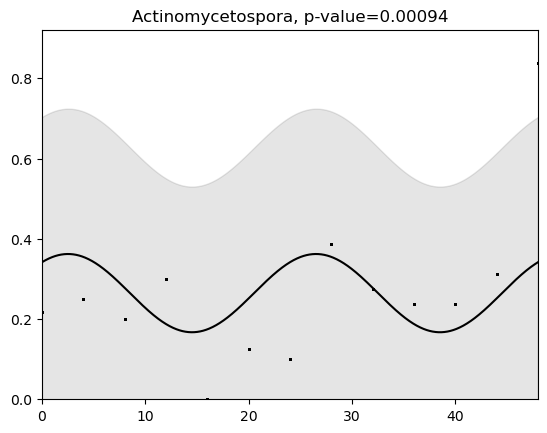

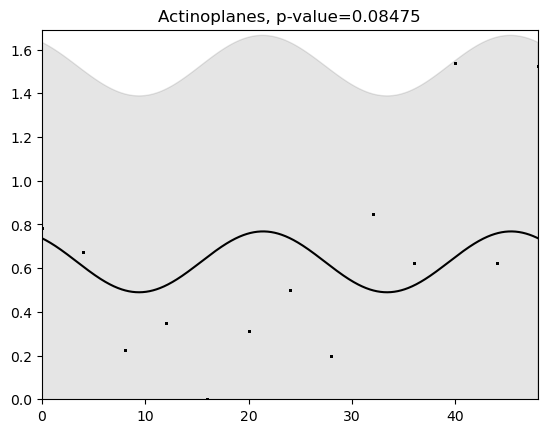

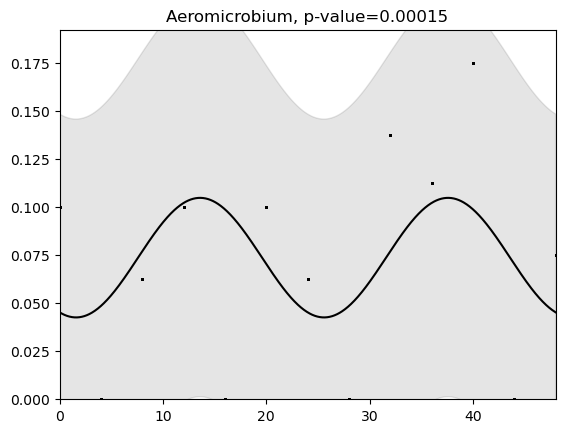

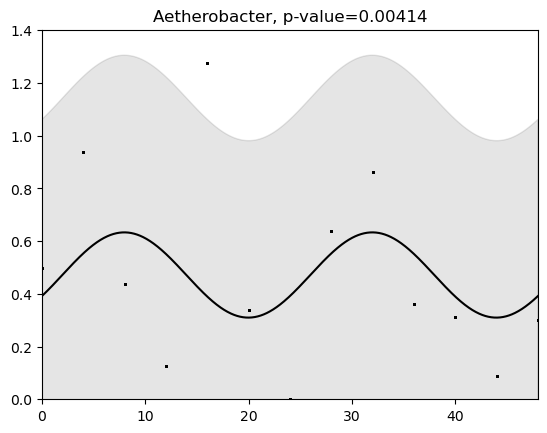

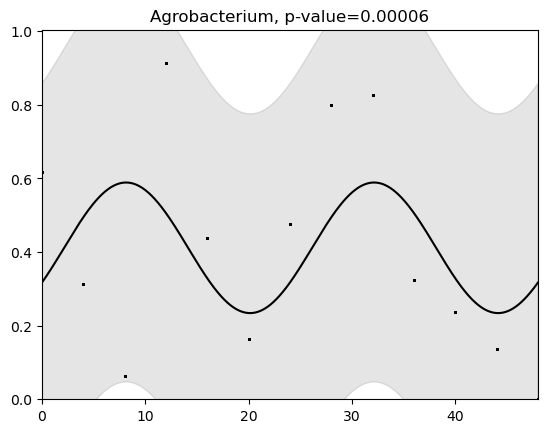

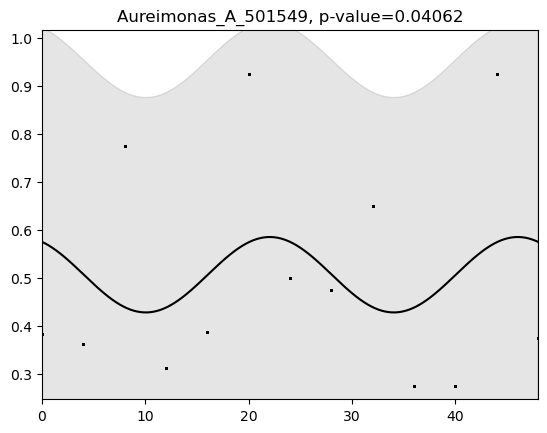

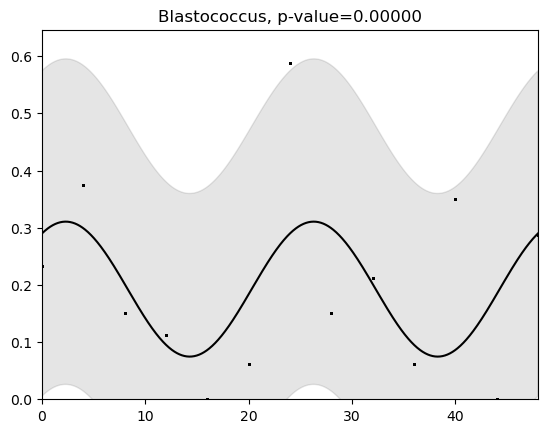

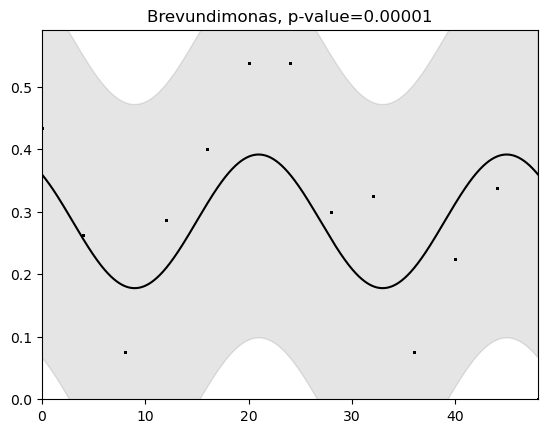

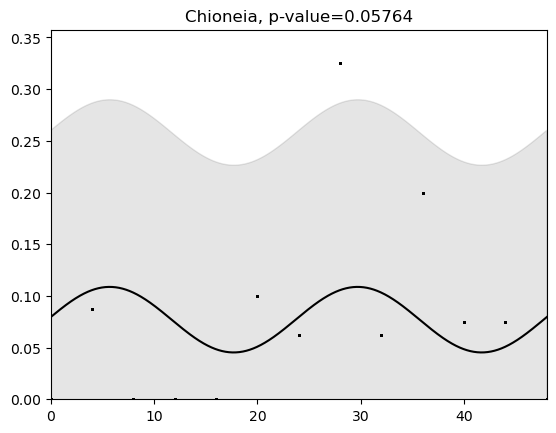

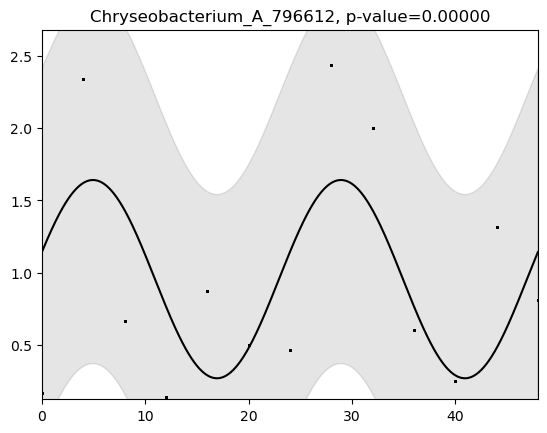

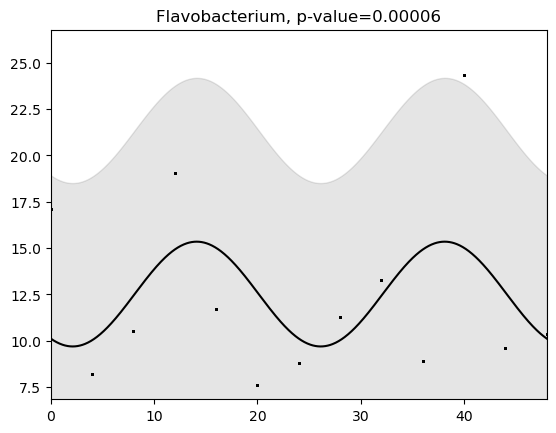

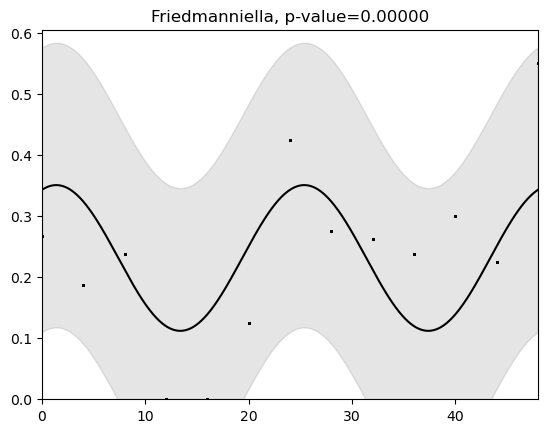

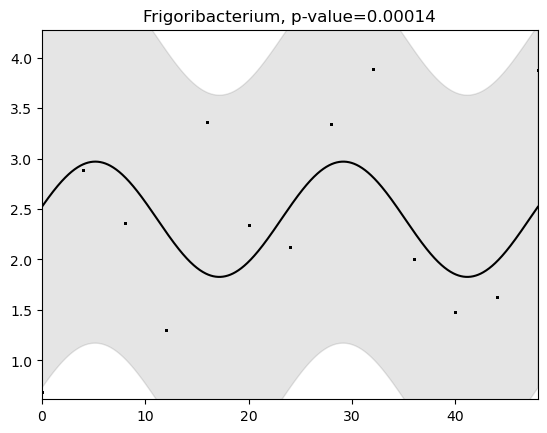

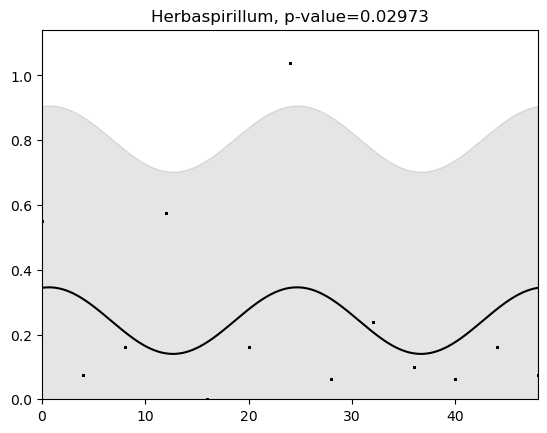

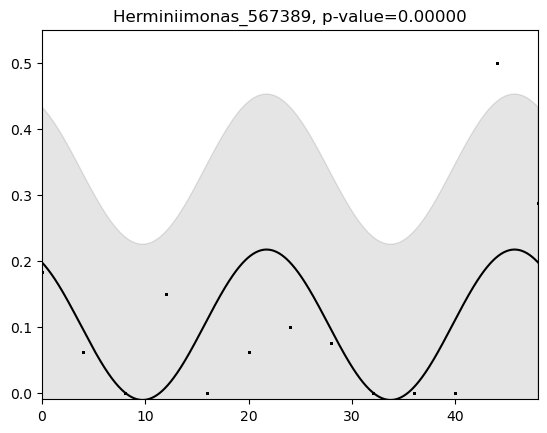

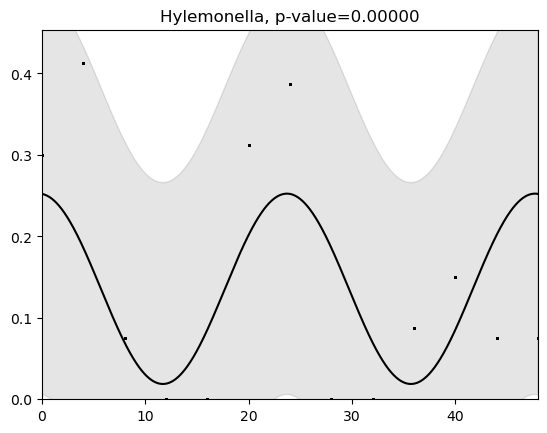

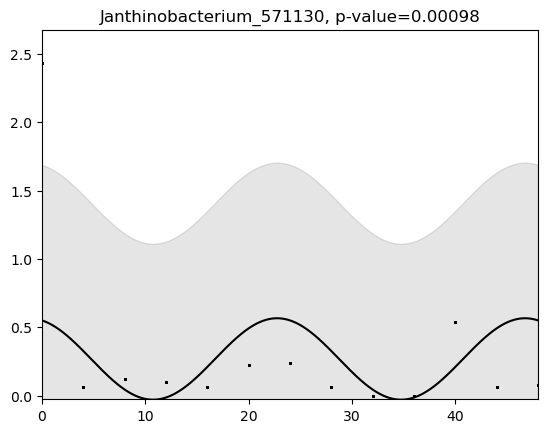

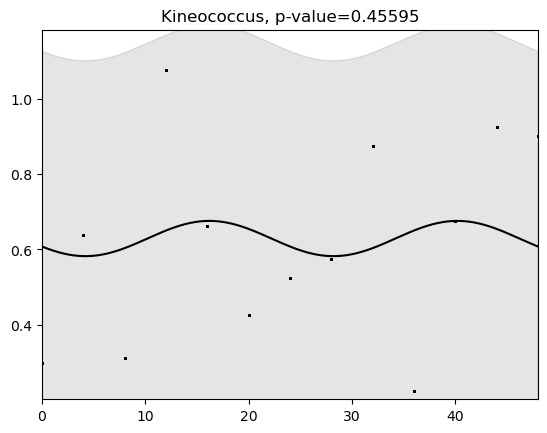

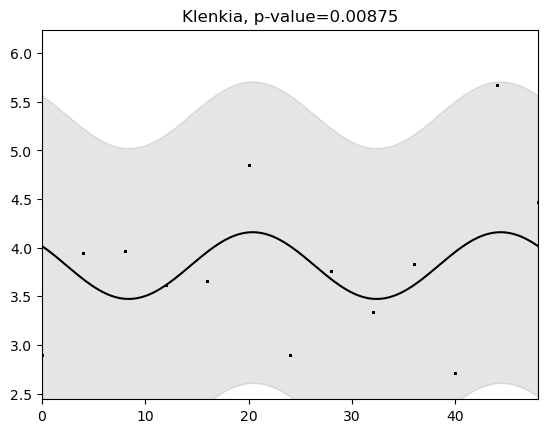

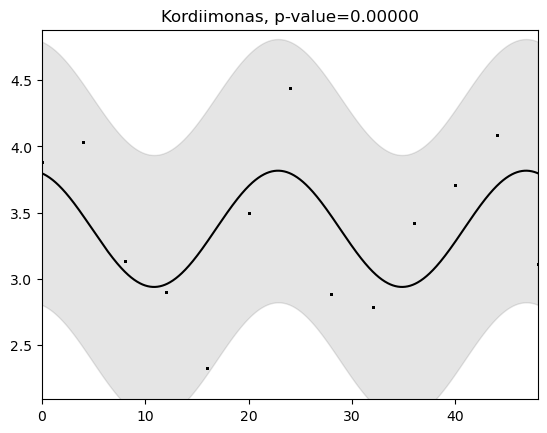

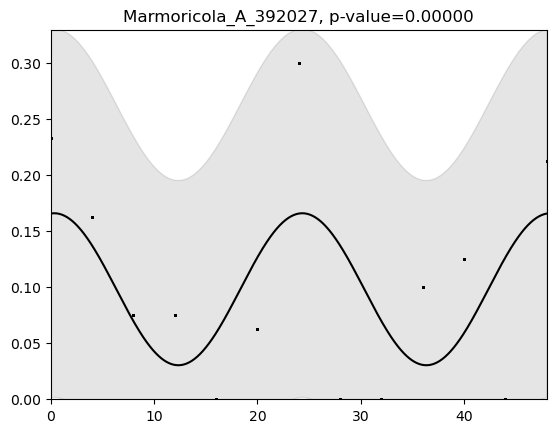

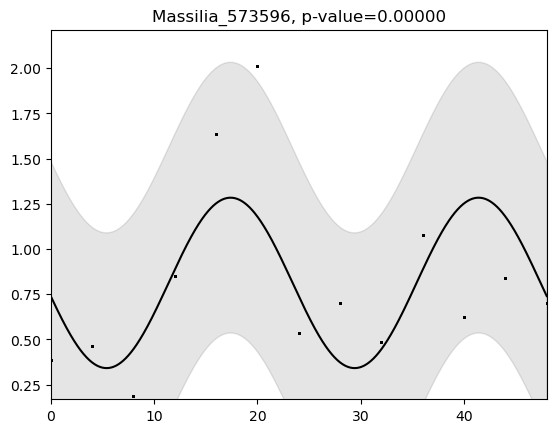

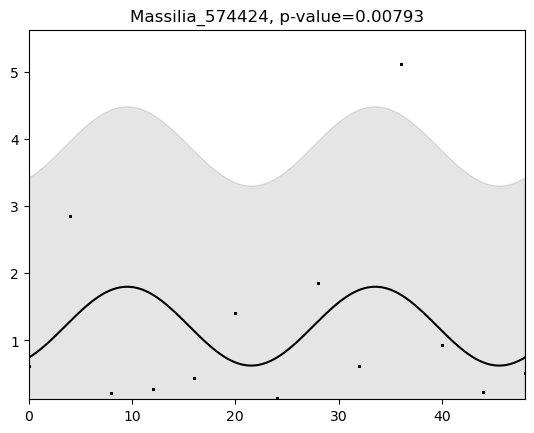

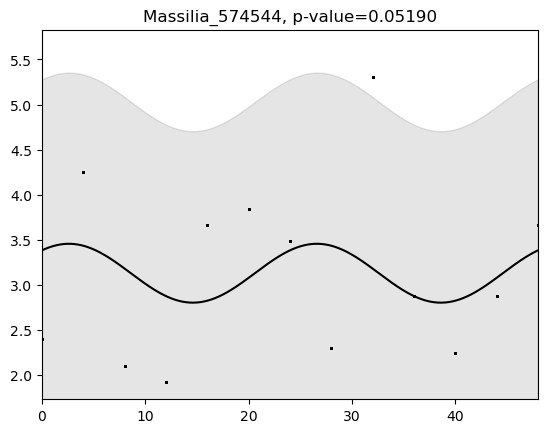

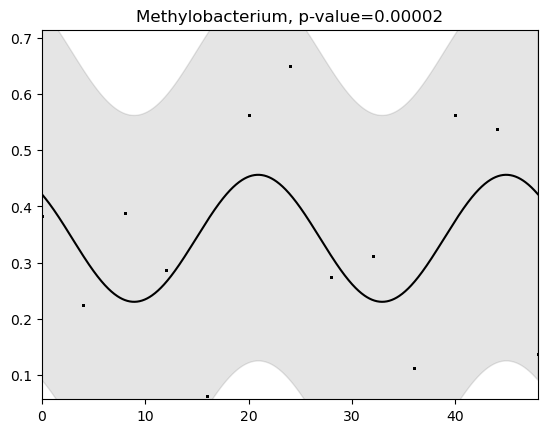

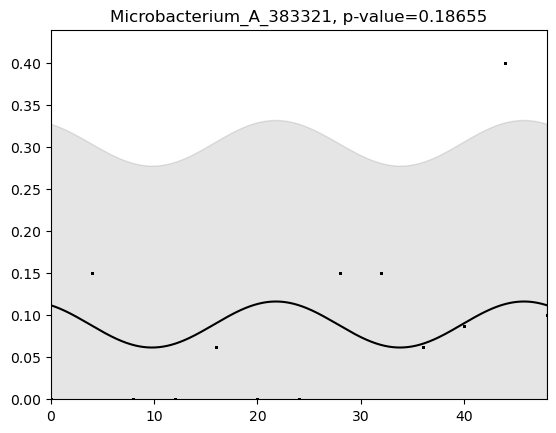

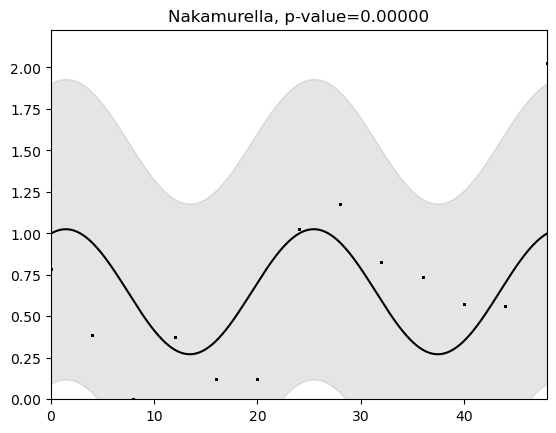

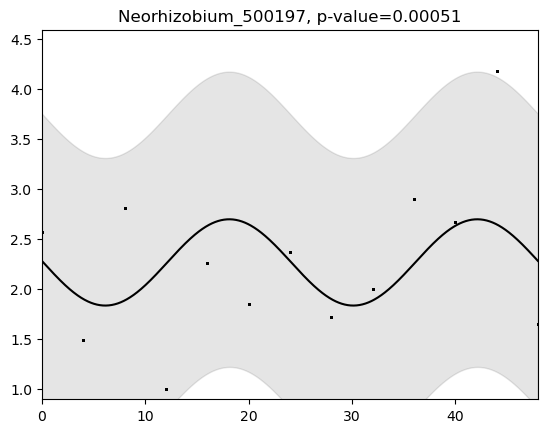

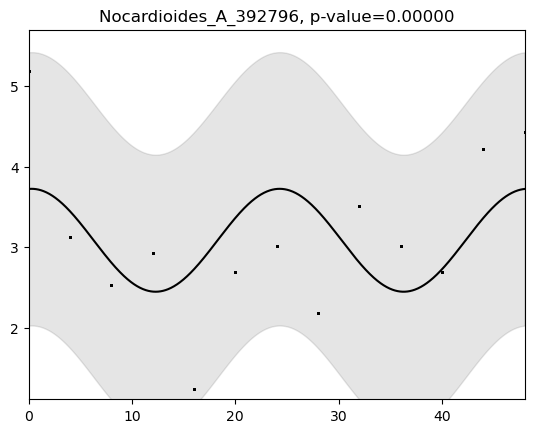

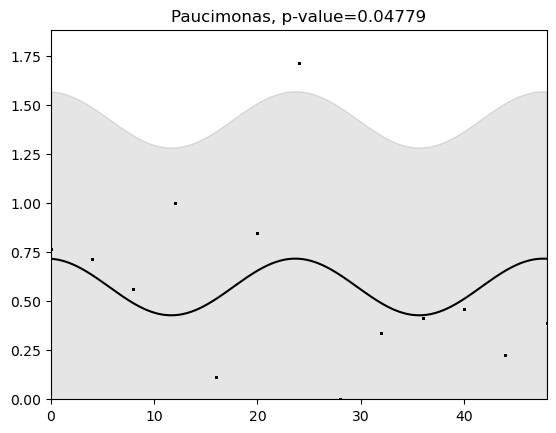

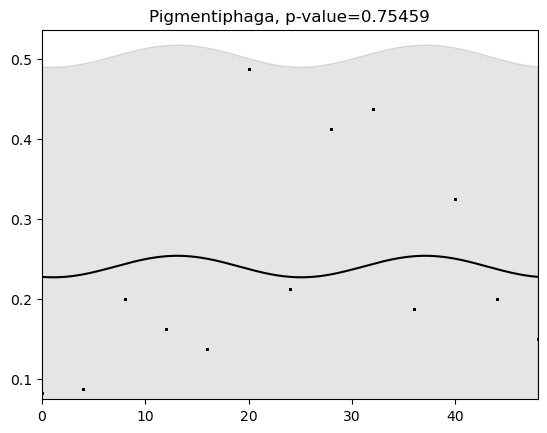

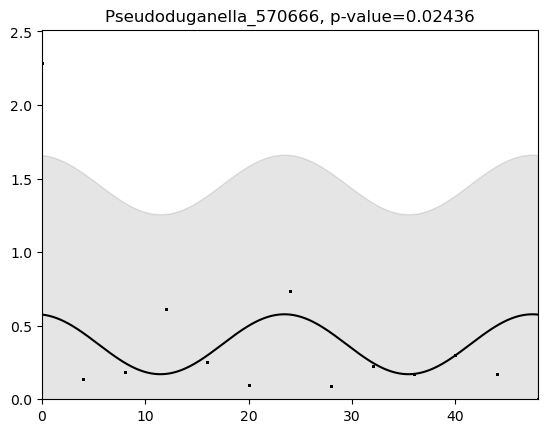

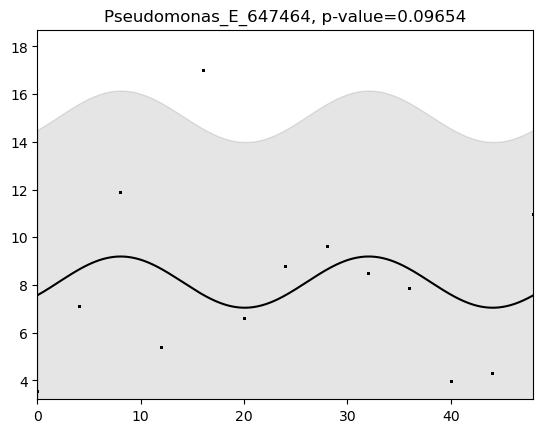

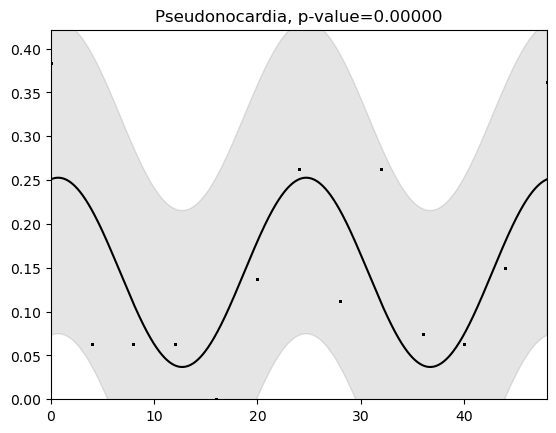

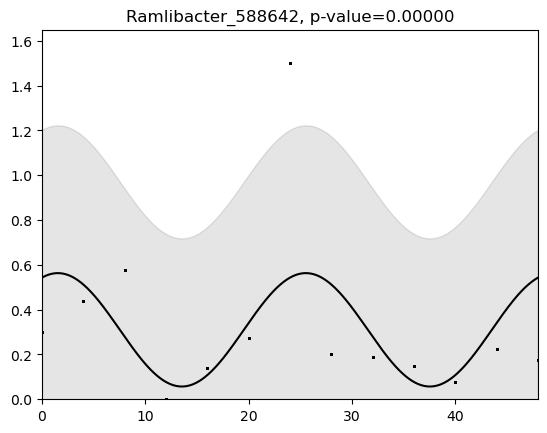

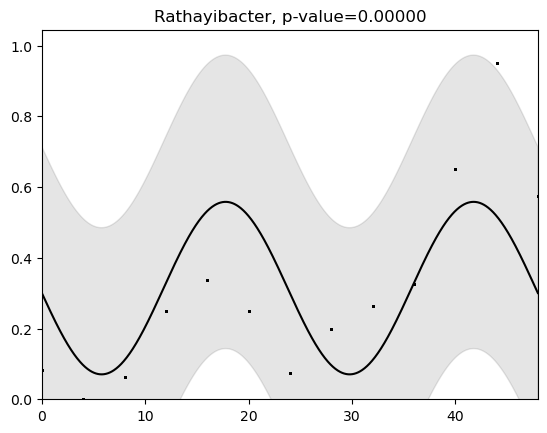

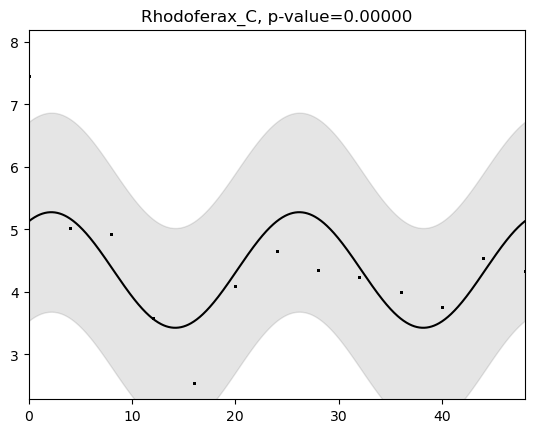

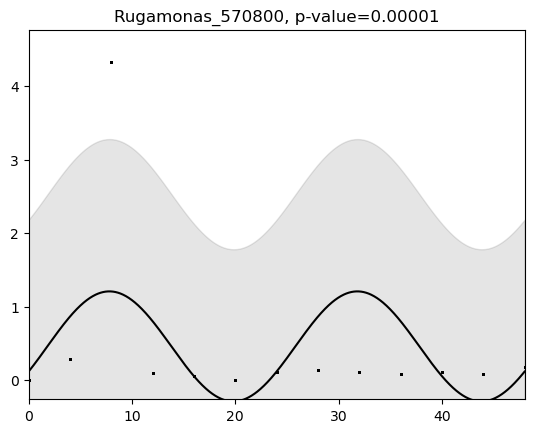

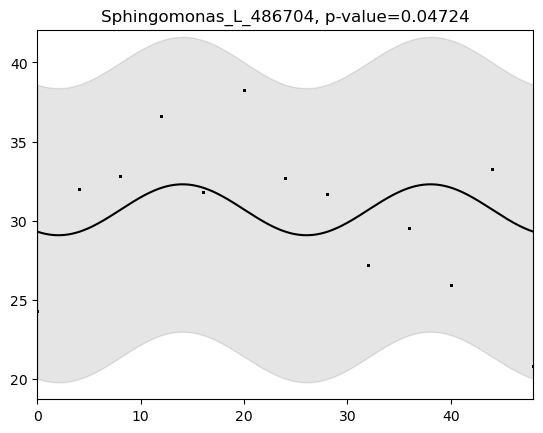

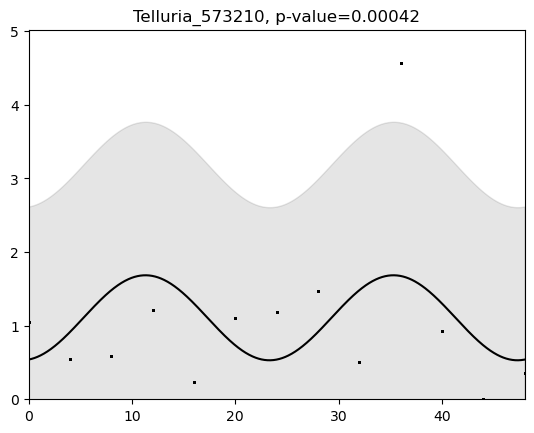

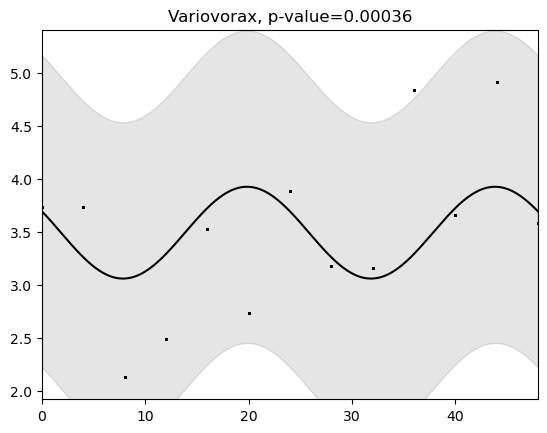

In [42]:
cosinor_results_2 = cosinor1.fit_group(timepoint_formatted_for_cosinor_2, period = [24])

In [43]:
cosinor_results_2

,test,period,p,q,amplitude,p(amplitude),q(amplitude),CI(amplitude),acrophase,p(acrophase),q(acrophase),CI(acrophase),acrophase[h]
0,Actinomycetospora,24.0,9.388177e-04,1.539330e-03,0.097511,1.133544e-04,1.821441e-04,"[0.04799952383991772, 0.1470227596288608]",-0.662848,1.107138e-02,1.815707e-02,"[-1.174239027583166, -0.15145645105393168]",2.531892
1,Actinoplanes,24.0,8.474928e-02,9.391137e-02,0.139230,2.477057e-02,2.744847e-02,"[0.01767525117502329, 0.2607846614488891]",0.679700,1.362863e-01,1.746168e-01,"[-0.2145271340963697, 1.5739272703971243]",21.403737
2,Aeromicrobium,24.0,1.456785e-04,2.844200e-04,0.031138,1.129300e-05,2.204824e-05,"[0.01723845230209256, 0.04503681284566098]",2.724635,1.208799e-30,1.239019e-29,"[2.2605751888324246, 3.1886949066332564]",13.592661
3,Aetherobacter,24.0,4.138914e-03,6.285018e-03,0.161722,6.744188e-04,1.024117e-03,"[0.06848950045541025, 0.254954476152249]",-2.089400,3.011300e-13,1.234633e-12,"[-2.650848922511398, -1.527950704770677]",7.980919
4,Agrobacterium,24.0,5.701202e-05,1.268721e-04,0.177314,3.514985e-06,7.882498e-06,"[0.10238580940854575, 0.2522414180602772]",-2.134232,5.245760e-24,2.688452e-23,"[-2.548183814682445, -1.7202792885658846]",8.152164
5,Aureimonas_A_501549,24.0,4.061811e-02,5.204195e-02,0.078562,1.019654e-02,1.306432e-02,"[0.01862704142798323, 0.1384978497891492]",0.508047,2.118667e-01,2.632283e-01,"[-0.2895456762088898, 1.3056395882589906]",22.059404
6,Blastococcus,24.0,2.323960e-07,7.940197e-07,0.117999,2.392745e-09,8.175212e-09,"[0.07925095321583916, 0.15674783420395508]",-0.603916,3.849459e-04,7.515610e-04,"[-0.9373211453365902, -0.270510735399975]",2.306789
7,Brevundimonas,24.0,5.353919e-06,1.463404e-05,0.106901,1.670844e-07,4.566975e-07,"[0.06685972712525885, 0.14694202190280753]",0.790966,4.102004e-05,9.893068e-05,"[0.4130053924229929, 1.1689263761776116]",20.978733
8,Chioneia,24.0,5.763830e-02,6.564362e-02,0.031701,1.535878e-02,1.749195e-02,"[0.006066543590614537, 0.057334821644659084]",-1.492250,1.058672e-04,2.170278e-04,"[-2.2466874744819156, -0.7378120134358931]",5.699974
9,Chryseobacterium_A_796612,24.0,2.197460e-10,1.519614e-09,0.685993,6.867782e-14,5.071875e-13,"[0.5064933958997013, 0.865493497752091]",-1.295021,4.774720e-25,2.796621e-24,"[-1.5405569548562688, -1.0494852020324257]",4.946616


In [53]:
cosinor_results_2.to_csv('/Users/michael/Data/Luke_terrace_experiment/Output_for_Luke/Circadian_experiment_2_microbiome_cosinor_results.csv', index = False)